In [1]:
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import os
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

2025-07-21 10:05:42.921851: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 10:05:44.165171: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# tfp particulars
tfd = tfp.distributions
root = tfd.JointDistributionCoroutine.Root

In [3]:
# Split the data into train and test data

def split_train_test_data(sub_image_df, path_to_df, n_forecasting):
    # join the paths
    complete_path_to_df = os.path.join(path_to_df, sub_image_df)
    # read the csv 
    read_df = pd.read_csv(complete_path_to_df)

    # split the data into train and test
    train_df = read_df.iloc[:-n_forecasting, :]
    print(train_df.shape)
    test_df = read_df.iloc[-n_forecasting:,:]
    print(test_df.shape)

    # get the obs data
    train_y = np.log(train_df['tassel_count'] + 1)
    test_y = np.log(test_df['tassel_count'] + 1)

    # make these float 32 for bayes ts implementation
    train_y = train_y.astype("float32")
    test_y = test_y.astype("float32")

    # these needs to be returned

    # also split the covariate data
    # but add an intercept before the split?
    read_df.insert(0, 'intercept', np.repeat(1, read_df.shape[0]))
    # make this float32 for bayes ts implementation
    read_df['intercept'] = read_df['intercept'].astype("float32")

    # now can extract the covariate data
    X_preds = read_df.drop(['tassel_count'], axis = 1).astype("float32")
    X_preds = X_preds.values
    print(X_preds.shape)
    n_preds = X_preds.shape[-1]
    return(train_y, test_y, X_preds, n_preds) 

In [4]:
# redefine the plot function
def plot_tassel_count_data(train_data, test_data, df_no, fig, ax):
    # if not fig_ax:
    #     fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # else:
    #     fig, ax = fig_ax
    ax.plot(train_data, color = 'blue', label="training data")
    ax.plot(test_data, color = 'lightcoral', label="testing data")
    ax.legend()
    ax.set(
        ylabel="Tassel counts" ,
        xlabel="Time",
        title = "Tassel count distribution for sub image " + str(df_no)
    )
    fig.autofmt_xdate()
    fig.show()
    return fig, ax

In [5]:
def get_prioirs_and_x_beta(X_pred, n_pred):
    beta = yield root(tfd.Sample(
        tfd.Normal(0., 1.),
        sample_shape=n_pred,
        name='beta'))
    x_beta = tf.einsum('ij,...j->...i', X_pred, beta)

    noise_sigma = yield root(tfd.HalfNormal(scale=0.1, name='noise_sigma'))

    intercept_data = X_pred[:,0]

    return (x_beta, intercept_data, noise_sigma)

In [6]:
train_tp = 13

In [7]:
def generate_model_ar_latent(preds_data, n_pred, training=True):

    @tfd.JointDistributionCoroutine
    def model_with_latent_ar():
        x_beta, intercept_data, noise_sigma = yield from get_prioirs_and_x_beta(preds_data, n_pred)
        
        # Latent AR(1)
        ar_sigma = yield root(tfd.HalfNormal(0.1, name='ar_sigma'))
        rho = yield root(tfd.Uniform(0, 1., name='rho'))
        def ar_fun(y):
            loc = tf.concat([tf.zeros_like(y[..., :1]), y[..., :-1]],
                            axis=-1) * rho[..., None]
            return tfd.Independent(
                tfd.Normal(loc=loc, scale=ar_sigma[..., None]),
                reinterpreted_batch_ndims=1)
        temporal_error = yield tfd.Autoregressive(
            distribution_fn=ar_fun,
            sample0=tf.zeros_like(intercept_data),
            num_steps=intercept_data.shape[-1],
            name='temporal_error')

        # Linear prediction
        y_hat = x_beta + temporal_error
        if training:
            y_hat = y_hat[..., :train_tp]

        # Likelihood
        observed = yield tfd.Independent(
            tfd.Normal(y_hat, noise_sigma[..., None]),
            reinterpreted_batch_ndims=1,
            name='observed'
        )

    return model_with_latent_ar

In [8]:
# need to run the following for each bayesian ts model

In [9]:
# define a function to plot the X_beta and temporal errors
def preds_and_temoral_error(mcmc_samples_data, preds_data, n_total_time_points, nchains):
    # plot components
    fig, ax = plt.subplots(2, 1, figsize=(10, 7.5), sharex=True)

    beta = mcmc_samples_data[0]
    seasonality_posterior = tf.einsum('ij,...j->...i', preds_data, beta)
    temporal_error = mcmc_samples_data[-1]

    for i in range(nchains):
        ax[0].plot(np.arange(n_total_time_points), seasonality_posterior[-100:, i, :].numpy().T, alpha=.05);
        ax[1].plot(np.arange(n_total_time_points), temporal_error[-100:, i, :].numpy().T, alpha=.05);

    ax[0].set_title('X_beta effect')
    ax[1].set_title('Temporal error')
    ax[1].set_xlabel("Day")
    fig.autofmt_xdate()
    

In [10]:
# Plot the forecated and actual values
def forecasted_and_actual_values_plot(ppc_sample_data, train_counts, test_counts, df_no, fig, ax):
    fitted_with_forecast = ppc_sample_data[-1].numpy()
    
    ax.plot(np.arange(20), fitted_with_forecast[:250, 0, :].T, color='gray', alpha=.1);
    ax.plot(np.arange(20), fitted_with_forecast[:250, 1, :].T, color='gray', alpha=.1);
    
    plot_tassel_count_data(train_counts, test_counts, df_no, fig, ax)
    average_forecast = np.mean(fitted_with_forecast, axis=(0, 1)).T
    ax.plot(np.arange(20), average_forecast, ls='--', label='latent AR forecast', color = 'red', alpha=.5);
    plt.xticks(np.arange(20))
    plt.legend()
    plt.show()

In [11]:
# create a function to get the posteriors and the trace plots with az
def get_nuts_values_and_posterior_plots(mcmc_samples_bts, sampler_stats_bts):
    nuts_trace_ar_latent = az.from_dict(posterior={k:np.swapaxes(v.numpy(), 1, 0) for k, v in mcmc_samples_bts._asdict().items()},
    sample_stats = {k:np.swapaxes(sampler_stats_bts[k], 1, 0)for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]})

    axes = az.plot_trace(nuts_trace_ar_latent, var_names=['beta', 'ar_sigma', 'rho', 'noise_sigma'], compact=True);

    plt.tight_layout()
    return(nuts_trace_ar_latent)

In [12]:
def posterior_vals(nuts_model):
    rho_values = nuts_model.posterior.rho
    print(rho_values.shape)
    ar_sigma_values = nuts_model.posterior.ar_sigma
    print(ar_sigma_values.shape)
    noise_sigma_values = nuts_model.posterior.noise_sigma
    print(noise_sigma_values.shape)
    beta_vals_all = nuts_model.posterior.beta
    print(beta_vals_all.shape)

    return(rho_values, ar_sigma_values, noise_sigma_values, beta_vals_all)

In [13]:
# colors for traceplots
color_list = ['cornflowerblue', 'lightsteelblue', 'blue', 'mediumblue', 'cyan', 'deepskyblue', 'steelblue', 'dodgerblue', 'lightslategray', 'mediumslateblue',
             'lightblue', 'teal', 'royalblue', 'indianred', 'deepskyblue', 'honeydew', 'lightseagreen', 'turquoise', 'cadetblue', 'tan', 'moccasin', 'burlywood',
             'peachpuff', 'powderblue', 'mediumaquamarine', 'powderblue', 'thistle', 'lavender', 'lightcyan', 'darkseagreen', 'honeydew', 'lightsteelblue', 'cadetblue']
len(color_list)

33

In [14]:
# color palattes for freq polygons
color_palletes_betas = ['Greys','Purples','Blues','Greens','Oranges','Reds','YlOrBr','YlOrRd','OrRd','PuRd','RdPu','BuPu','GnBu','PuBu','YlGnBu',
 'PuBuGn','BuGn','YlGn','Greys','Purples','Blues','Greens','Oranges','Reds','YlOrBr','YlOrRd','OrRd','PuRd','RdPu','BuPu','GnBu','PuBu', 'YlGnBu']
len(color_palletes_betas)

33

In [15]:
# define a function for this?

# for a chosen parameter - param

def get_trace_plots(ax, param, color, string_params):
    ax.plot(param.T, color = color, alpha = 0.5)
    ax.set_title("Trace plot for " + string_params, fontsize=10, fontweight="bold")

In [16]:
# Create a function for this?
def get_freq_curves(ax, param, color_palette, string_params):
    sns.kdeplot(data=param.T, fill=False, ax=ax, legend = False, palette = color_palette)
    ax.set_title("Frequency plot for " + string_params, fontsize=10, fontweight="bold")

In [17]:
def fit_Bayes_TS_model(csv_file, forecasting_steps, path_to_preprocessed_dfs, sub_image_number, n_features, figure_folder_path, forecasts_folder_path, nchains):
    # get the counts and predictors
    Train_Y, Test_Y, X_preds_only, n_predictors = split_train_test_data(csv_file, path_to_preprocessed_dfs, forecasting_steps)
    # plot the train and test counts
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    plot_tassel_count_data(Train_Y, Test_Y, sub_image_number, fig, ax)
    # define the mcmc function
    run_mcmc = tf.function(tfp.experimental.mcmc.windowed_adaptive_nuts , autograph=False, jit_compile=True)
    # define the latet ar model
    gam_with_latent_ar = generate_model_ar_latent(X_preds_only, n_predictors, training=True)
    # plot samples from prior predictive distribution
    plt.figure(figsize = (10,8))
    plt.plot(tf.transpose(gam_with_latent_ar.sample(500)[-1]))
    plt.show()
    # run the mcmc with nuts sampler
    mcmc_samples, sampler_stats = run_mcmc(1000, gam_with_latent_ar, n_chains=4, num_adaptation_steps=1000, seed=tf.constant([36245, 734565], dtype=tf.int32), observed=Train_Y.T)
    # get the posterior values for parameters and the posterioir predictions
    gam_with_latent_ar_full = generate_model_ar_latent(X_preds_only, n_predictors, training=False)
    posterior_dists, ppc_samples = gam_with_latent_ar_full.sample_distributions(value=mcmc_samples)
    # plot the posteriors ? for betas and temporal errors
    preds_and_temoral_error(mcmc_samples, X_preds_only, n_total_time_points = 20, nchains = 4)
    # Plot the forecated and actual values
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # fig_ax = (fig, ax)
    forecasted_and_actual_values_plot(ppc_samples, Train_Y, Test_Y, sub_image_number, fig, ax)
    # Get the posterior plots
    nuts_output = get_nuts_values_and_posterior_plots(mcmc_samples, sampler_stats)
    # recreate this plot
    rho_values, ar_sigma_values, noise_sigma_values, beta_vals_all = posterior_vals(nuts_output)
    # get the betas gathered and plot them all in a single plot
    all_betas = [beta_vals_all[: ,: , i] for i in range(n_features)]
    # recreate the plot
    fig, axs = plt.subplots(4, 2, figsize=(10, 10))
    get_trace_plots(axs[0, 0], rho_values, 'palevioletred', 'rho')
    get_trace_plots(axs[1, 0], noise_sigma_values, 'blue', 'noise sigma')
    get_trace_plots(axs[2, 0], ar_sigma_values, 'indianred', 'ar sigma')
    for i in range(33):
        get_trace_plots(axs[3, 0], all_betas[i], color_list[i], 'betas')
    fig.tight_layout()
    get_freq_curves(axs[0, 1], rho_values, 'Blues', 'rho')
    get_freq_curves(axs[1, 1], noise_sigma_values, 'Purples', 'noise sigma')
    get_freq_curves(axs[2, 1], ar_sigma_values, 'Greens', 'ar sigma')
    for i in range(33):
        get_freq_curves(axs[3, 1], all_betas[i], color_palletes_betas[i], 'betas')
    fig.tight_layout()
    # plt.plot(all_betas[i].T, color = color_list[i], alpha = 0.5)
    figure_path_and_name = figure_folder_path + '/' + 'all_trace_plots_sub_' + str(sub_image_number) + '.png'
    plt.savefig(figure_path_and_name)
    plt.show()
    # get the forecasted values
    forecasted_values = ppc_samples[-1].numpy()
    averaged_forecast = np.mean(forecasted_values, axis=(0, 1)).T
    print(forecasted_values.shape, averaged_forecast.shape)
    # we may need to store the averaged forecasts - extract these first for the test set only
    test_averaged_forecast = averaged_forecast[-forecasting_steps:]
    test_all_forecasts = forecasted_values[:,:,-forecasting_steps:]
    # create a dataframe for true and averaged forecasts for test data
    final_forecasted_values = pd.DataFrame(zip(Test_Y, test_averaged_forecast), columns = ['True_value', 'Forecasted_value'])
    # save the avrage and all forecasts for future use
    avg_frcst_file_name = forecasts_folder_path + '/' + 'averaged_forecasts_sub_' + str(sub_image_number) + '.csv'
    final_forecasted_values.to_csv(avg_frcst_file_name, index = False)
    all_frcst_file_name = forecasts_folder_path + '/' + 'all_forecasts_sub_' + str(sub_image_number) + '.npy'
    np.save(all_frcst_file_name, test_all_forecasts)
    # get the parameter summary
    parameter_summary = az.summary(nuts_output)
    parameter_summary_file_name = forecasts_folder_path + '/' + 'posterior_parameter_summary_sub_' + str(sub_image_number) + '.csv'
    parameter_summary.to_csv(parameter_summary_file_name, index = False)
    # save the posterior predicted values for other parameters
    rho_file_name = forecasts_folder_path + '/' + 'rho_values_sub_' + str(sub_image_number) + '.npy'
    np.save(rho_file_name, rho_values)
    noise_sigma_file_name = forecasts_folder_path + '/' + 'noise_sigma_values_sub_' + str(sub_image_number) + '.npy'
    np.save(noise_sigma_file_name, noise_sigma_values)
    ar_sigma_file_name = forecasts_folder_path + '/' + 'ar_sigma_values_sub_' + str(sub_image_number) + '.npy'
    np.save(ar_sigma_file_name, ar_sigma_values)
    beta_file_name = forecasts_folder_path + '/' + 'beta_values_sub_' + str(sub_image_number) + '.npy'
    np.save(beta_file_name, all_betas)
    return(final_forecasted_values)

In [18]:
# csv_file_name = 'extracted_features_sub_window_1.csv'
forecasting_steps = 7
path_to_precessed_dfs = 'all_preprocessed_data/Block_0103/TS_ready_data_frames/'
# sub_image_number = 0
n_features = 33
nchains = 4
figure_folder_path = 'log_of_counts/figures/block_0103'
forecasts_folder_path = 'log_of_counts/forecasted_counts/block_0103'
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# fig_ax = (fig, ax)

In [19]:
# get rid of the checkpointing folder
sub_image_files = [file for file in os.listdir(path_to_precessed_dfs) if file[-3:] == 'csv']
sub_image_files.sort()

In [20]:
# add the 10, 11 at the end
im_files = ['extracted_features_sub_window_10.csv', 'extracted_features_sub_window_11.csv']

In [21]:
other_files = [i for i in sub_image_files if i not in im_files]

In [22]:
sub_image_files = other_files + im_files

In [23]:
sub_image_files

['extracted_features_sub_window_0.csv',
 'extracted_features_sub_window_1.csv',
 'extracted_features_sub_window_2.csv',
 'extracted_features_sub_window_3.csv',
 'extracted_features_sub_window_4.csv',
 'extracted_features_sub_window_5.csv',
 'extracted_features_sub_window_6.csv',
 'extracted_features_sub_window_7.csv',
 'extracted_features_sub_window_8.csv',
 'extracted_features_sub_window_9.csv',
 'extracted_features_sub_window_10.csv',
 'extracted_features_sub_window_11.csv']

In [24]:
sub_image_numbers = np.arange(12)

In [25]:
sub_image_numbers

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

(13, 33)
(7, 33)
(20, 33)


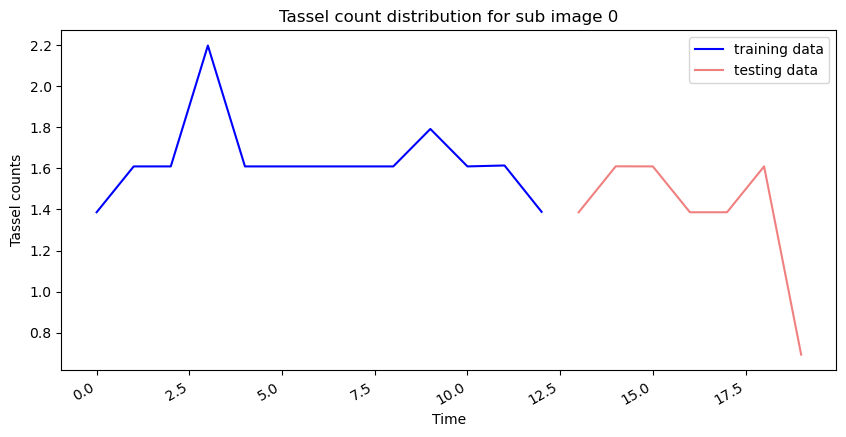

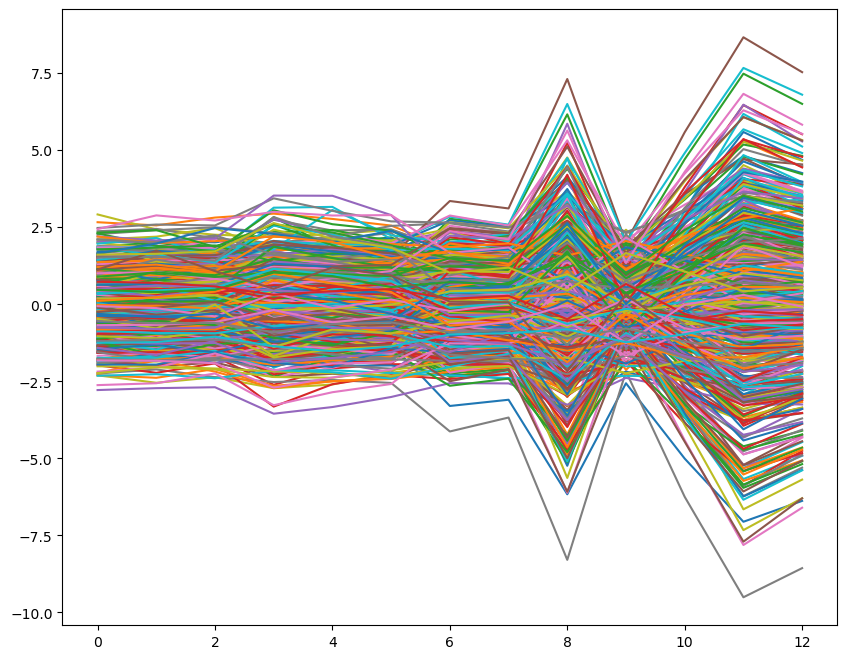

2024-11-11 20:26:21.689389: I external/local_xla/xla/service/service.cc:168] XLA service 0x5626e7c76c20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-11-11 20:26:21.689458: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-11-11 20:26:22.300990: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator chain_of_default_joint_bijector_of_restructure/ldj_reduction_ndims/assert_equal_1/Assert/Assert
2024-11-11 20:26:22.321549: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator chain_of_default_joint_bijector_of_restructure_of_jointmap_of_reshape_and_reshape_1_and_reshape_2_and_reshape_3_and_reshape_4/ldj_reduction_ndims_5/assert_equal_1/Assert/Assert
2024-11-11 20:26:22.413859: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-

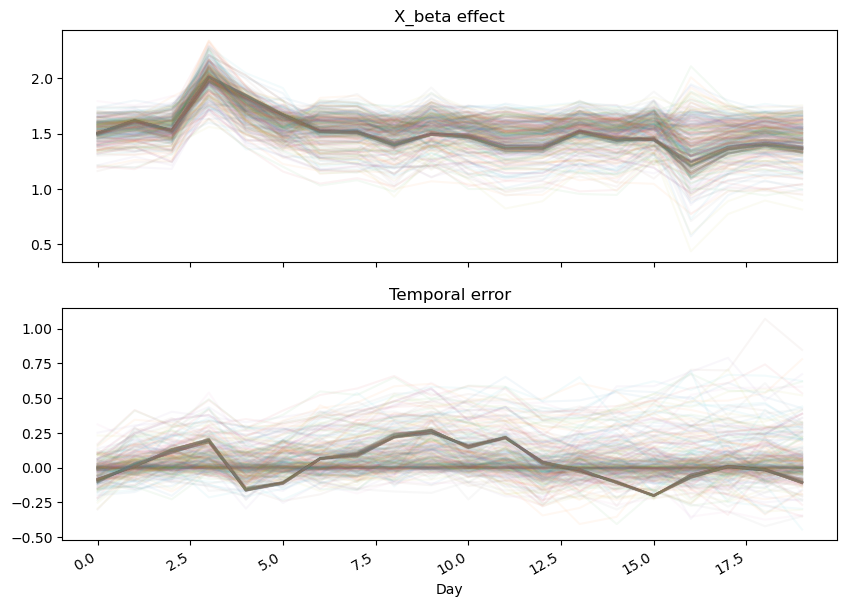

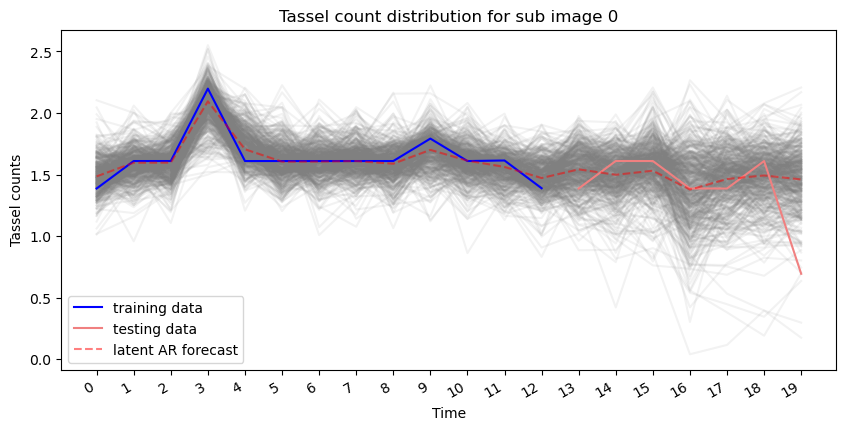

(4, 1000)
(4, 1000)
(4, 1000)
(4, 1000, 33)


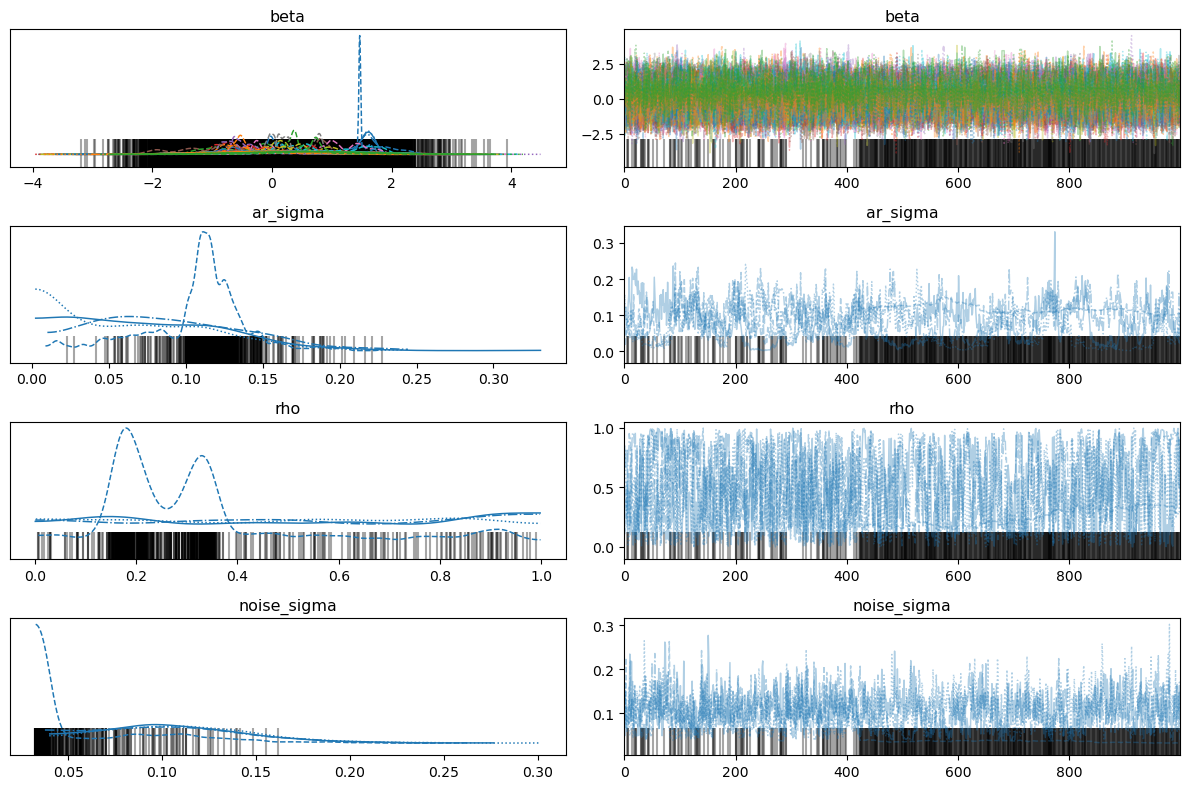

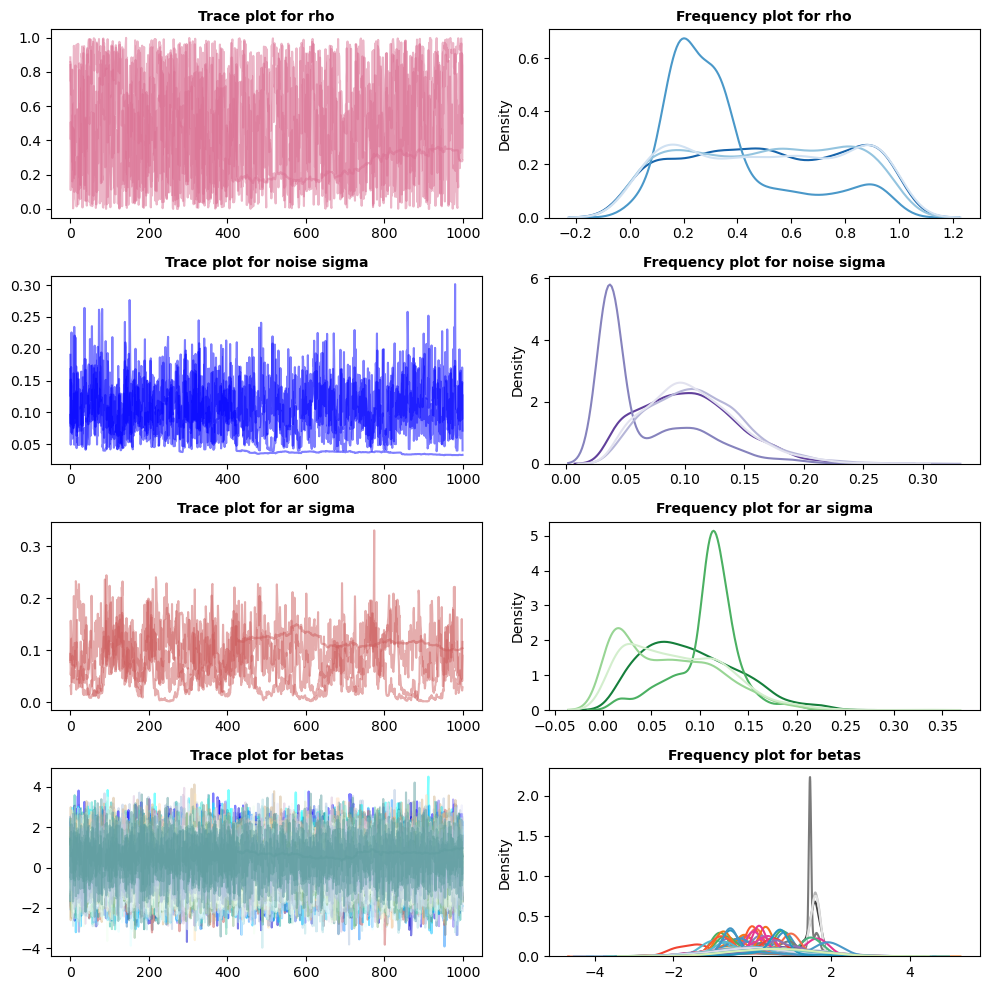

(1000, 4, 20) (20,)
(13, 33)
(7, 33)
(20, 33)


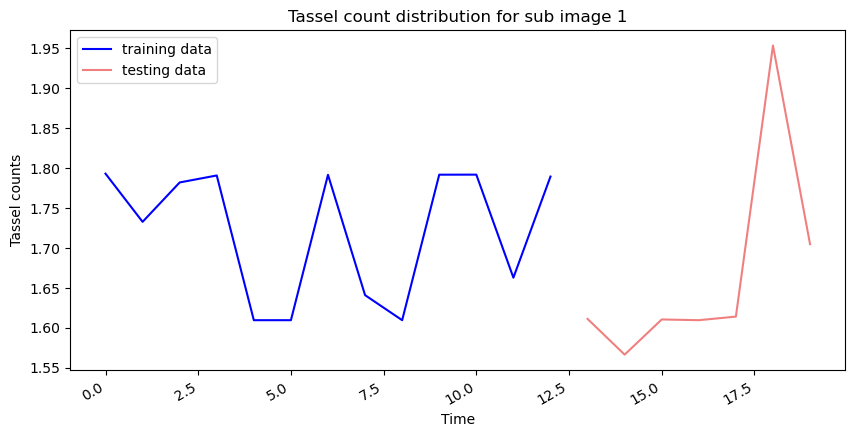

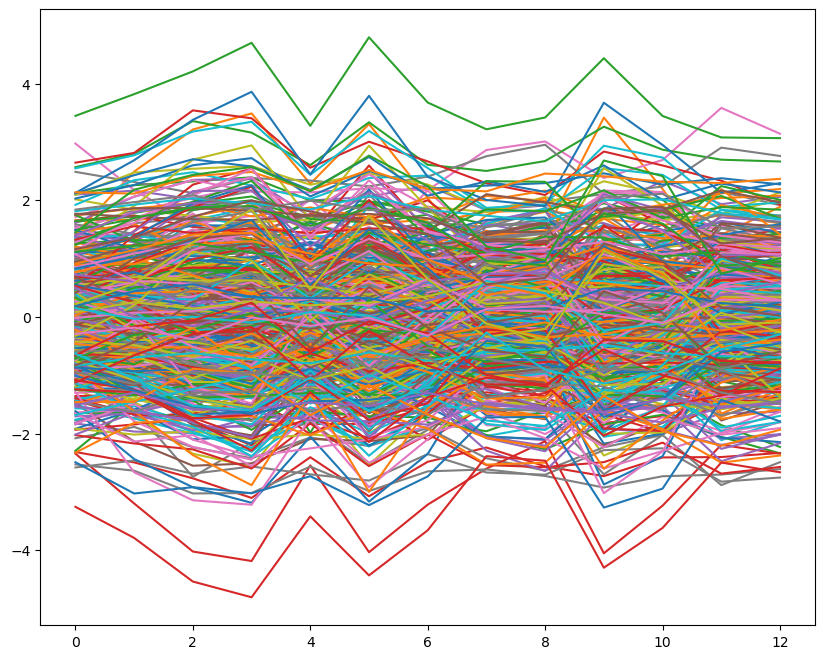


KeyboardInterrupt



In [26]:
%%time
all_dfs = []
for i in np.arange(12):
    get_df = fit_Bayes_TS_model(sub_image_files[i], forecasting_steps, path_to_precessed_dfs, sub_image_numbers[i], n_features, figure_folder_path, forecasts_folder_path, nchains)
    all_dfs.append(get_df)

In [27]:
# check if the average forecasted values match with all forecasts we stored.

In [28]:
# path to stored forecasts
path_to_stored_forecasts = 'log_of_counts/forecasted_counts/block_0103/'

In [29]:
# list the contents here
contents  = os.listdir(path_to_stored_forecasts)
contents.sort()

In [30]:
# get only the all and average forecasts
all_forecasts_list = [file for file in contents if file[:3]=='all']
all_forecasts_list.sort()
avg_forecasts_list = [file for file in contents if file[:3] == 'ave']
avg_forecasts_list.sort()

In [31]:
# read in the npy files
all_forecasts_sub_0 = np.load(os.path.join(path_to_stored_forecasts, 'all_forecasts_sub_0.npy'))
avg_forecast_sub_0 = pd.read_csv(os.path.join(path_to_stored_forecasts, "averaged_forecasts_sub_0.csv"))

In [32]:
stored_averages = avg_forecast_sub_0[['Forecasted_value']].values.flatten()
# convert this to float 32
stored_averages = np.float32(stored_averages)

In [33]:
stored_averages

array([1.5418409, 1.4976798, 1.5306908, 1.3775381, 1.4631821, 1.4923296,
       1.4596237], dtype=float32)

In [34]:
all_forecasts_sub_0.shape

(1000, 4, 7)

In [35]:
avg_from_all_forecasts = all_forecasts_sub_0.mean(axis = (0,1))

In [36]:
avg_from_all_forecasts

array([1.5418409, 1.4976798, 1.5306908, 1.3775381, 1.4631821, 1.4923296,
       1.4596237], dtype=float32)

In [37]:
np.mean(stored_averages == avg_from_all_forecasts)

1.0

In [38]:
# convert this to a function to test for all subwindows
def match_averages(path_to_stored_forecasts, all_forecasts_file_name, average_forecasts_file_name):
    # contents_all  = os.listdir(path_to_stored_forecasts)
    # contents_all.sort()
    # all_forecasts_files = [file for file in contents_all if file[:3]=='all']
    # all_forecasts_files.sort()
    # avg_forecast_files = [file for file in contents_all if file[:3] == 'ave']
    # avg_forecast_files.sort()
    # read in the npy files and the csv files
    all_forecasts = np.load(os.path.join(path_to_stored_forecasts, all_forecasts_file_name))
    avg_forecast = pd.read_csv(os.path.join(path_to_stored_forecasts, average_forecasts_file_name))
    stored_average = avg_forecast[['Forecasted_value']].values.flatten()
    # convert these to float32
    stored_average = np.float32(stored_average)
    # compute the means from all forecasts
    avg_from_all_forecast = all_forecasts.mean(axis = (0,1))
    print(np.mean(stored_average == avg_from_all_forecast))

In [39]:
for i in range(0,12):
    match_averages(path_to_stored_forecasts, all_forecasts_list[i], avg_forecasts_list[i])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [40]:
# Okay the stored forecasts match with the computed averages from stored all forecasts

In [41]:
np.exp(stored_averages) - 1

array([3.6731853, 3.471303 , 3.6213684, 2.9651277, 3.3196836, 3.4474444,
       3.3043394], dtype=float32)